## Importing swe-BERT for initial training

In [1]:
!pip install transformers
!pip install tqdm

import torch
import numpy as np
import math
from transformers import BertTokenizer, BertForSequenceClassification, BertModel
from transformers.modeling_outputs import BaseModelOutputWithPooling
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
# collab command to install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda


In [2]:
from torch.utils.data import Dataset


import re
def clean_txt (text):
  text = re.sub("¹", "", text)
  text=re.sub("(\\W)+","  ", text)
  return text


class SNLIDataset(Dataset):

    def __init__(self, filename, max_size=None):
        super().__init__()
        self.xs = []
        self.ys = []
        self.sentence_lengths = np.array([])
        count = 0
        with open(filename, encoding="utf-8") as source:
            for i, line in enumerate(source):
                if i == 0:
                  continue
                # print(line)
                if max_size and i >= max_size:
                    break
                try:
                  sentence, sentiment_value = line.rstrip().split('|') # Delimeter to be chosen
                  count += 1
                except:
                  print( "Error when processing the following data ", [line.rstrip().split('|')])
                # print(sentence)
                self.xs.append(clean_txt(sentence))
                self.ys.append(int(sentiment_value)) # make sure negative/neutral/positive is labelled correct
                self.sentence_lengths = np.append(self.sentence_lengths, len(sentence.split(" ")))

    def __getitem__(self, idx):
        return self.xs[idx], self.ys[idx]

    def __len__(self):
        return len(self.xs)

class SNLIDataset_shell_class(SNLIDataset):
    def __init__(self, xs, ys, sentence_lengths):
      self.xs = xs
      self.ys = ys
      self.sentence_lengths = sentence_lengths

In [3]:


def divide_dataset_to_train_and_test(SNLIDataset, percentage_to_train):
    random_indices = torch.randperm(len(SNLIDataset.xs))
    num_of_sent_in_train = math.floor(len(SNLIDataset.xs)*(percentage_to_train))
 
    train_dataset_xs = np.array(list(map(SNLIDataset.xs.__getitem__, random_indices[0:num_of_sent_in_train])))
    train_dataset_ys = np.array(list(map(SNLIDataset.ys.__getitem__, random_indices[0:num_of_sent_in_train])))
    train_dataset_sent_lengths = np.array(list(map(SNLIDataset.sentence_lengths.__getitem__, random_indices[0:num_of_sent_in_train])))


    test_dataset_xs = np.array(list(map(SNLIDataset.xs.__getitem__, random_indices[num_of_sent_in_train:])))
    test_dataset_ys = np.array(list(map(SNLIDataset.ys.__getitem__, random_indices[num_of_sent_in_train:])))
    test_dataset_sent_lengths = np.array(list(map(SNLIDataset.sentence_lengths.__getitem__, random_indices[num_of_sent_in_train:])))
  
    train_dataset = SNLIDataset_shell_class(train_dataset_xs, train_dataset_ys, train_dataset_sent_lengths)

    test_dataset = SNLIDataset_shell_class(test_dataset_xs, test_dataset_ys, test_dataset_sent_lengths)
    

    return train_dataset, test_dataset



## Create all datasets

In [4]:
financial_news_train_dataset = SNLIDataset('./Financial Data/financial_phrases_labeled_psv_train.csv')
financial_news_test_dataset = SNLIDataset('./Financial Data/financial_phrases_labeled_psv_test.csv')
amazon_review_dataset = SNLIDataset('./amazon-review-data/amazon_review_data_psv.csv')
# hp_n, mp_n, neg_n, neu_n = SNLIDataset('./sweOnlyProcData/highPosNews.txt'), SNLIDataset('./sweOnlyProcData/mediumPosNews.txt'), SNLIDataset('./sweOnlyProcData/negativeNews.txt'), SNLIDataset('./sweOnlyProcData/neutralNews.txt')

# data = financial_news_train_dataset[121]

amazon_review_train_dataset, amazon_review_test_dataset = divide_dataset_to_train_and_test(amazon_review_dataset, 0.9)


print(len(amazon_review_dataset))
print(len(amazon_review_train_dataset))
print(len(amazon_review_test_dataset))


30000
27000
3000


In [5]:
print(financial_news_train_dataset.xs[:10]) # Dataseten är på något vis olika formatterad som gör att det blir fel senare när man tränar modellen
print(amazon_review_train_dataset.xs[:10])

['Finska  flygbolaget  Finnair  inleder  de  tillfälliga  uppsägningarna  av  kabinpersonal  i  februari  2010  ', 'Motsvarande  ökning  av  aktiekapitalet  totalt  300  00  euro  registrerades  i  det  finska  handelsregistret  den  8  maj  2008  ', 'Under  det  tredje  kvartalet  av  räkenskapsåret  2008  svängde  Efore  till  en  nettoförlust  på  400  000  EUR  jämfört  med  en  nettovinst  på  200  000  EUR  för  motsvarande  period  2007  ', 'ALEXANDRIA  Virginia  15  oktober  Aaron  Moss  från  Hampshire  Storbritannien  har  utvecklat  en  dekorativ  design  för  en  telefon  meddelade  US  Patent  amp  Trademark  Office  ', 'Vaisala  Oyj  Börsmeddelande  26  03  2010  klo  09  00  1  1  Årsstämman  i  Vaisala  Oyj  beslutade  den  25  mars  2010  att  godkänna  bolagets  årsredovisning  för  2009  ', 'Produktens  framkantsvikning  maximerar  vädertålighet  och  möjliggör  en  sömlös  takfinish  ', 'Raute  är  noterat  på  den  nordiska  börsen  i  Helsingfors  ', 'KESKO  FOOD 

## Dataset analysis
Here we analyze the length distribution for each dataset

NameError: ignored

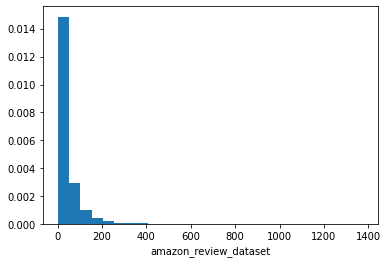

In [ ]:
import matplotlib.pyplot as plt

def plot_data_length(sentence_lengths, datasetName, resolution=1):
    plot_data_length.total_plots += 1
    plt.figure(plot_data_length.total_plots)
    plt.hist(sentence_lengths, bins=int(np.max(sentence_lengths)*resolution), density=True)
    plt.xlabel(datasetName)
plot_data_length.total_plots = 0
plot_data_length(amazon_review_dataset.sentence_lengths, "amazon_review_dataset", 1/50)
plot_data_length(np.concatenate([financial_news_test_dataset.sentence_lengths, financial_news_train_dataset.sentence_lengths]), "financial_news_dataset", 1/4)
plot_data_length(np.concatenate([hp_n.sentence_lengths, mp_n.sentence_lengths, neg_n.sentence_lengths, neu_n.sentence_lengths]), "Own-collected-news", 1/500)


## Import swedish bert

In [6]:
tokenizer = BertTokenizer.from_pretrained('KB/bert-base-swedish-cased', do_lower_case=True)
bert = BertModel.from_pretrained('KB/bert-base-swedish-cased')

Some weights of the model checkpoint at KB/bert-base-swedish-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
tokenized = tokenizer(text=amazon_review_train_dataset[1][0], padding='longest', return_tensors='pt')
print(amazon_review_train_dataset[1][0])
print(tokenized.input_ids)
print(tokenized)

älskade  det  här  och  älskade  att  vi  hade  ett  spel  för  de  quot  små  quot  tjejerna  att  spela  på  vår  babyshower
tensor([[    2,  9360,    82,   382,    36,  9360,    48,   186,   365,   137,
           442,    43,   102, 17510,   129,  1459, 17510,   129, 17203,    48,
          2055,    68,   671, 18511, 17168,     6,     3]])
{'input_ids': tensor([[    2,  9360,    82,   382,    36,  9360,    48,   186,   365,   137,
           442,    43,   102, 17510,   129,  1459, 17510,   129, 17203,    48,
          2055,    68,   671, 18511, 17168,     6,     3]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1]])}


### Define colate function that tokenizes

In [8]:
def get_split(text1):
  l_total = []
  l_parcial = []
  if text1.shape[0]//150 >0:
    n = text1.shape[0]//150
  else: 
    n = 1
  for w in range(n):
    if w == 0:
      l_parcial = text1[:200]
      l_total.append(l_parcial)
    else:
      l_parcial = text1[w*150:w*150 + 200]
      l_total.append(l_parcial)
  return l_total

In [9]:
def tensor_split(text1, seq_size=200, overlap=50, add_to_start = 2):
  l_total = []
  l_parcial = []
  cls_tokens = torch.unsqueeze(torch.as_tensor([add_to_start]* text1.shape[0]), dim=1)
  if text1.shape[1]//(seq_size-overlap) >0:
    n = text1.shape[1]//(seq_size-overlap)
  else: 
    n = 1
  for w in range(n):
    if w == 0:
      l_parcial = torch.concat([cls_tokens, text1[:,:seq_size]], dim=1)
      l_total.append(l_parcial.to(device))
    else:
      l_parcial = torch.concat([cls_tokens, text1[:,w*(seq_size-overlap):w*(seq_size-overlap) + seq_size]], dim=1)
      l_total.append(l_parcial.to(device))
  return l_total





In [10]:
def our_collate_fn(data):
    x = [a[0] for a in data]
    y = [a[1] for a in data]
    tokenized = tokenizer(text=x, padding='longest', return_tensors='pt')

    return tokenized['input_ids'], torch.as_tensor(y), tokenized['attention_mask']

In [11]:
from torch.utils.data import DataLoader

def create_training_examples(dataset, batch_size = 64, seq_size = 200, overlap = 50):
    batch_sort_order = np.array_split(dataset.sentence_lengths.argsort()[::-1], round(len(dataset) / batch_size))
    tokenized_train_data = DataLoader(dataset, collate_fn=our_collate_fn, batch_sampler=batch_sort_order) #

    for bindex, (bx, by, ba) in enumerate(tokenized_train_data):
        yield tensor_split(bx, seq_size, overlap), tensor_split(ba, seq_size, overlap, add_to_start=1), by.to(device)
                




In [12]:
import torch.nn as nn

rnn = nn.LSTM(10, 20, batch_first = True)
input = torch.randn(3, 5, 10)
h0 = torch.randn(1, 3, 20)
c0 = torch.randn(1, 3, 20)
output, (hn, cn) = rnn(input, (h0, c0))

print("Input shape: {}".format([*input.shape]))
print("Output shape: {}".format([*output.shape]))
print("Last hidden state shape: {}".format([*hn.shape]))

Input shape: [3, 5, 10]
Output shape: [3, 5, 20]
Last hidden state shape: [1, 3, 20]


In [55]:
import torch.nn as nn

class DocBert(nn.Module):
    def __init__(self, bert, hidden_dim=20, num_labels=3):
        super().__init__()
        self.bert =  bert.to(device) # INTE BertForSequenceClassification
        self.lstm = nn.LSTM(bert.config.hidden_size, hidden_dim, batch_first=True).to(device)
        # Input [Batch_size, sequence_length, input_size]
        # Output [1, batch_size, hidden_dim]
        self.linear = nn.Linear(hidden_dim, num_labels).to(device)
    
    def forward(self, x_seqs, a_seqs):
      output = []
      for x_seq, a_seq in zip(x_seqs, a_seqs):
        output.append(self.bert(x_seq, a_seq).pooler_output) # Only get the embedding of the [CLS]-token [batch_size, number_of_sequences, input_size]
      _ , (output, _) = self.lstm(torch.stack(output, dim=1)) # [1, batch_size, hidden_dim]
      return self.linear(torch.squeeze(output, dim=0))
      #   bertified_seqs.append()
      # self.lstm(, )

    def predict(self, x_seq, a_seq): # No attention mask here, correct?
      guesses = []
      output = self.forward(x_seq, a_seq)
      batch_guess = torch.argmax(output, dim=1)
      return batch_guess

    def accuracy(self, sequences, batch_size=8):
      current_correct = 0
      current_tried = 0
      for x_seq, a_seq, by in create_training_examples(sequences, batch_size=batch_size):
        prediction = self.predict(x_seq, a_seq)
        current_correct += torch.sum(prediction==by)
        current_tried += batch_size
      return current_correct / current_tried




#### Functions for training and testing a model

In [50]:
import torch.nn.functional as F
def train_docbert(pretrained_bert, dataset, hidden_dim=20, num_labels=3, epochs=1):
  docbert = DocBert(pretrained_bert, hidden_dim, num_labels)
  optimizer = torch.optim.Adam(docbert.parameters())
  for epoch in range(epochs):
    i = 0
    tot_loss = 0
    for x_seqs, a_seqs, by in create_training_examples(dataset, batch_size=8, seq_size=200, overlap=50):
      optimizer.zero_grad()
      preds = docbert.forward(x_seqs, a_seqs)
      loss = F.cross_entropy(preds, by)
      tot_loss += loss
      i += 1
      if i % 10 == 0:
        print(tot_loss / 10)
        tot_loss = 0
      loss.backward()
      optimizer.step()
    return docbert



In [60]:
docbert = DocBert(bert)

In [61]:
preds = docbert.accuracy(amazon_review_test_dataset)
print(preds)

tensor(0.4157, device='cuda:0')


In [ ]:
from torch.utils.data import DataLoader
from tqdm import tqdm
def train_model(train_data, batch_size):
  batch_sort_order = np.array_split(train_data.sentence_lengths.argsort()[::-1], round(len(train_data) / batch_size))
  tokenized_train_data = DataLoader(train_data, collate_fn=our_collate_fn, batch_sampler=batch_sort_order) #
  
  # print(tokenized_train_data)
  # for batch in tokenized_train_data:
  #     for sent_pair in batch[0]:
  #       print(sent_pair)
  #     print(batch)
  #     break
  

  model = BertForSequenceClassification.from_pretrained('KB/bert-base-swedish-cased', num_labels=3)
  model = model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
  # softmax = torch.nn.Softmax(dim=1)
  epochs = 1

  for _ in range(epochs):
    model.train()

    with tqdm(total=len(train_data)) as pbar:

      for bindex, (bx, by, ba) in enumerate(tokenized_train_data):
        bx, by, ba = bx.to(device), by.to(device), ba.to(device)
        optimizer.zero_grad()
        # forward pass
        train_output = model(bx, labels=by, attention_mask=ba)
        # backward pass
        train_output.loss.backward()
        optimizer.step()
        pbar.update(len(bx))
  return model

def evaluate_model(model, valid_data, batch_size):
    batch_sort_order = np.array_split(valid_data.sentence_lengths.argsort()[::-1], round(len(valid_data) / batch_size))
    tokenized_valid_data = DataLoader(valid_data, batch_sampler=batch_sort_order, collate_fn=our_collate_fn)
    model.eval()
    valids = []
    for bx, by, ba in tokenized_valid_data:
      with torch.no_grad():
        bx, by, ba = bx.to(device), by.to(device), ba.to(device)
        # forward pass
        try:
          eval_output = model(bx, attention_mask=ba)
          guess = torch.argmax(eval_output.logits, dim=1)
          valids.append(sum(guess == by)/len(by))
        except Exception as e:
          print(bx.shape, by.shape)
          print(ba.shape)
          print(e)
        
    print('Accuracy: {}'.format(sum(valids)/len(valids)))


## Train and save the financial model

In [ ]:
amazon_trained_model = train_model(amazon_review_dataset, 64)
evaluate_model(amazon_trained_model, amazon_review_dataset)
amazon_trained_model.save_pretrained("./amazon_trained_model")

Some weights of the model checkpoint at KB/bert-base-swedish-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at KB/bert-base-swedi

RuntimeError: ignored

In [ ]:
financial_trained_model = train_model(financial_news_train_dataset, 64)
evaluate_model(financial_trained_model, financial_news_test_dataset, 64)
# financial_trained_model.save_pretrained("./financial_trained_model")

Some weights of the model checkpoint at KB/bert-base-swedish-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at KB/bert-base-swedi

Accuracy: 0.78515625


## Load the financial model and evaluate it on similar test-data 
accuracy should be 88%+

In [ ]:
# loadedModel = BertForSequenceClassification.from_pretrained("./financial_trained_model/")
evaluate_model(financial_trained_model, financial_news_test_dataset, 32)



Accuracy: 0.7852193117141724


In [ ]:

evaluate_model(loadedModel, amazon_review_dataset, 16)

NameError: ignored